# HW9: Forecasting Solar Cycles

Below is the notebook associated with HW\#9. You can run the notebook in two modes. If you have the `emcee` and `corner` packages installed on your machine, along with the data files, just keep the following variable set to `False`. If you are running it in a Google colab notebook, set it to `True` so that it will grab the packages and files. Remember that the Google colab environment will shutdown after ~1 hour of inactivity, so you'll need to keep interacting with it or else will lose the data.

A script version of this file will also be provided to you, but you cannot use this in a Google colab environment

In [1]:
COLAB = False

In [2]:
if COLAB:
    # Install emcee package
    !pip install emcee
    # Install corner package
    !pip install corner    
    # Grab sunspot data file
    !wget -O SN_m_tot_V2.0.txt https://raw.githubusercontent.com/mtlam/ASTP-720_F2020/master/HW9/SN_m_tot_V2.0.txt

In [5]:
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
#import sys
#!{sys.executable} -m pip install corner
import emcee
import corner
%matplotlib inline

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## Define the (log-)priors

Here, the function should take a vector of parameters, `theta`, and return `0.0` if the it is in the prior range and `-np.inf` if it is outside. This is equivalent to a uniform prior over the parameters. You can, of course, define a different set of priors if you so choose!

In [45]:
def lnprior(theta):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
        
    Returns
    -------
    Value of log-prior.    
    """
    retval = 0.0
    for i in range(len(theta)):
        if np.abs(theta[i]) > 400.0:
            retval = -np.inf
    return(retval)

## Define the (log-)likelihood

In [53]:
def lnlike(theta, data):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
    data : np.ndarray
        
        
    Returns
    -------
    Value of log-likelihood   
    """
    residuals = 0
    for j in range(1, len(data)):
        amp = theta[0]
        phase = j % theta[1]
        phi0 = theta[2]
        paramtot = np.abs(amp*np.sin(data[j-1]*phase + phi0))
        diff = data[j] - paramtot
        residuals += diff**2
    return(np.log(residuals))

## Define total (log-)probability

No need to change this if the other two functions work as described.

In [54]:
def lnprob(theta, data):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data)

## Set up the MCMC sampler here

In [55]:
# Number of walkers to search through parameter space
nwalkers = 10
# Number of iterations to run the sampler for
niter = 50000
# Initial guess of parameters. For example, if you had a model like
# s(t) = a + bt + ct^2
# and your initial guesses for a, b, and c were 5, 3, and 8, respectively, then you would write
# pinit = np.array([5, 3, 8])
# Make sure the guesses are allowed inside your lnprior range!
pinit = np.array([200, 22, 7])
# Number of dimensions of parameter space
ndim = len(pinit)
# Perturbed set of initial guesses. Have your walkers all start out at
# *slightly* different starting values
p0 = [pinit + 1e-4*pinit*np.random.randn(ndim) for i in range(nwalkers)]

## Load the data, plot to show

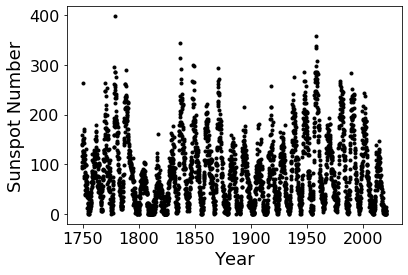

In [56]:
# Data: decimal year, sunspot number
decyear, ssn = np.loadtxt("SN_m_tot_V2.0.txt", unpack=True, usecols=(2, 3))
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

## Run the sampler

In [57]:
# Number of CPU threads to use. Reduce if you are running on your own machine
# and don't want to use too many cores
nthreads = 4
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ssn,), threads=nthreads)
# Run the sampler. May take a while! You might consider changing the 
# number of iterations to a much smaller value when you're testing. Or use a 
# larger value when you're trying to get your final results out!
sampler.run_mcmc(p0, niter, progress=True)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:03:53<00:00, 13.04it/s]


State([[-306.68961099  364.3504496  -332.78275101]
 [-350.91320035 -331.32450732  -86.08245615]
 [ 302.0864966   360.53144941  375.51247517]
 [ 299.27530999 -238.84234972 -137.9415143 ]
 [  41.50788803 -232.37324474   59.30353375]
 [-392.02139918 -350.13093626  355.99440273]
 [-337.07945088  103.38957394  -27.02745702]
 [-299.55800769 -245.64610776  330.35669901]
 [  39.70475868   59.22184427 -132.85685472]
 [ 199.10952904 -140.86398256   31.63645574]], log_prob=[18.23500294 18.62699444 18.28308028 18.19472315 17.05527096 18.88876977
 18.50714392 18.21904134 17.07379062 17.28747791], blobs=None, random_state=('MT19937', array([1383639122, 2630322968, 3156837928, 3400753781, 3165116949,
       1300994362, 1360051305, 2202639987, 2801124487,  299948555,
       3508919896, 1202401777, 4266371929, 3745010853, 3091408527,
       1770687838,  748539523, 3602134394, 2405969897, 3336686244,
       2649611416, 3102074815, 3745038559,  632123804, 1610557928,
       4091619442, 2820797520,  25926

## Get the samples in the appropriate format, with a burn value

In [58]:
# Burn-in value = 1/4th the number of iterations. Feel free to change!
burn = int(0.25*niter)
# Reshape the chains for input to corner.corner()
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

## Make a corner plot

You should feel free to adjust the parameters to the `corner` function. You **should** also add labels, which should just be a list of the names of the parameters. So, if you had two parameters, $\phi_1$ and $\phi_2$, then you could write:

```
labels = [r"$\phi_1$", r"$\phi_2$"]
```

and that will make the appropriate label in LaTeX (if the distribution is installed correctly) for the two 1D posteriors of the corner plot.

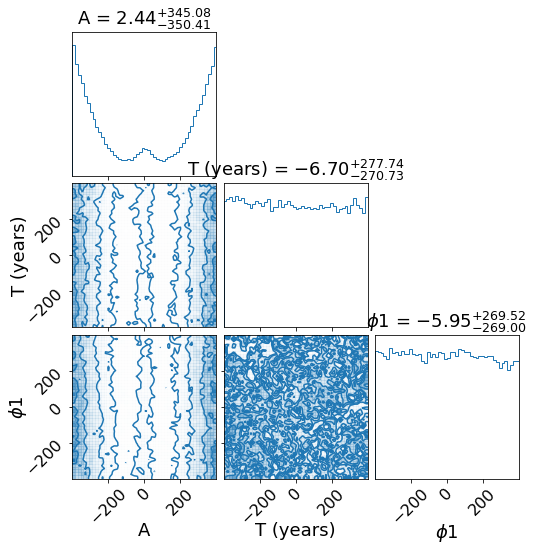

In [59]:
labels = ['A', 'T (years)', r'$\phi1$']
fig = corner.corner(samples, bins=50, color='C0', smooth=0.5, plot_datapoints=False, plot_density=True, \
                    plot_contours=True, fill_contour=False, show_titles=True, labels=labels)
fig.savefig("corner.png")
show()